In [391]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import lmfit as lm
SEED = 35010732 # from random.org
np.random.seed(SEED)

In [392]:
#ODE's
#dP0 = -b*P0i*Ri + u*P1i
#dP1 = b*P0i*Ri - u*P1i - b*P1i*Ri + u*P2i
#dP2 = b*P1i*Ri - u*P2i
#dmRNA = mr*P0i + lr - mRNAi*g1
#dR = mRNAi*tr - Ri*g2 -b*P0i*Ri -b*P1i*Ri +u*P1i +u*P2i
#dG = mRNAi*tr - Gi*g2
def gfp(vec, t, lr, mr,tr,g1,g2,b,u):
    P0i=vec[0]      #Free GFP & TetR promoter
    P1i=vec[1]    #1 bound GFP & TetR promoter
    P2i=vec[2]     #2 bound GFP & TetR promoter
    mRNAi=vec[3]   #mRNA levels
    Ri=vec[4]     #TetR Protein levels
    Gi=vec[5]    #GFP protein levels
    vec = [P0i,P1i,P2i,mRNAi,Ri,Gi]
    return np.array([-b*P0i*Ri + u*P1i,
                    b*P0i*Ri - u*P1i - b*P1i*Ri + u*P2i,
                    b*P1i*Ri - u*P2i,
                    mr*P0i + lr - mRNAi*g1,
                    mRNAi*tr - Ri*g2 -b*P0i*Ri -b*P1i*Ri +u*P1i +u*P2i,
                    mRNAi*tr - Gi*g2])

In [393]:
gfpi =pd.read_excel("12_8_20_comp_gfp_intensity.xlsx")
gfpi_data_cut = gfpi[0:150]
gfpi_data_cut = gfpi_data_cut.values.T
#gfpi_data.shape
gfpi_data_cut.shape
time = gfpi_data_cut[0].astype(np.double)
gfp_data = gfpi_data_cut[1:].astype(np.double)

Text(0, 0.5, 'integrated intensity')

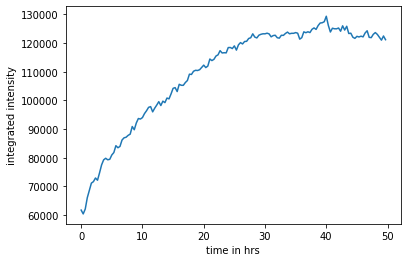

In [394]:
for data in gfp_data[:1]:
    plt.plot(time, data)
plt.xlabel("time in hrs")
plt.ylabel("integrated intensity")

In [395]:
noise=np.sqrt(np.abs(data))

In [396]:
def DEODE(t,t0,lr,mr,tr,g1,g2,b,u,offset):
    f = np.zeros(np.shape(t))
    idx_after = np.array(t>t0, dtype=bool)
    dt = t[idx_after] - t0
    if dt[0]>0:
        addzero =True
        dt = np.concatenate(([0.0],dt))
    else:
        addzero =False
    result = odeint(gfp,vec0, dt, args=(lr,mr,tr,g1,g2,b,u))
    if addzero:
        f[idx_after] = result[:,5][1:]
    else:
        f[idx_after] = result[:,5]
    return f + offset

def DEODE(t,t0,lr,mr,tr,g1,g2,b,u,offset):
    f = np.zeros(np.shape(t))
    idx_after = np.array(t>t0, dtype=bool)
    dt = t[idx_after] - t0
    if dt[0]>0:
        addzero = True
        dt = np.concatenate(([0.0],dt))
    else:
        addzero =False
    result = odeint(gfp, vec0, dt, args=(lr,mr,tr,g1,g2,b,u))
    if addzero:
        f[idx_after] = result[:,5][1:]
    else:
        f[idx_after] = result[:,5]
    return f + offset

In [426]:
mRNA0=2              #TetR mrna  
GFP10= 10       #GFP
TetR0= 1                    #unbound/active TetR protein ogv=0
P00= 1                    #0 TetR bound to TetR promoter
P10= 1                     #1 TetR bound to TetR promoter
P20= 2                     #2 TetR bound to TetR promoter
vec0 = [mRNA0, GFP10, TetR0, P00, P10, P20]

In [443]:
DE_model = lm.Model(DEODE)
pars = DE_model.make_params()
pars['t0'].set(value=0.8,vary=True)
pars['lr'].set(value = 5, vary = True)
pars['mr'].set(value = 19.32, vary = True)
pars['tr'].set(value = 150, vary = True)
pars['g1'].set(value = .2, vary =True)
pars['g2'].set(value = 0.046, vary = True)
pars['b'].set(value = 0.2, vary = True)
pars['u'].set(value =22.8, vary = True)
pars['offset'].set(value= 62000,vary= False)

out = DE_model.fit(data,pars,t=time,weights=1/noise)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(DEODE)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 150
    # variables        = 8
    chi-square         = 34280.5128
    reduced chi-square = 241.412062
    Akaike info crit   = 830.754556
    Bayesian info crit = 854.839638
[[Variables]]
    t0:      0.79018175 +/- 0.02635436 (3.34%) (init = 0.8)
    lr:      4.90714595 +/- 0.17613078 (3.59%) (init = 5)
    mr:      20.1370525 +/- 0.60441227 (3.00%) (init = 19.32)
    tr:      149.539022 +/- 4.39283795 (2.94%) (init = 150)
    g1:      0.20088060 +/- 0.00540563 (2.69%) (init = 0.2)
    g2:      0.04564562 +/- 0.00117174 (2.57%) (init = 0.046)
    b:       0.20315674 +/- 0.00573037 (2.82%) (init = 0.2)
    u:       22.2847796 +/- 0.81850147 (3.67%) (init = 22.8)
    offset:  62000 (fixed)
[[Correlations]] (unreported correlations are < 0.250)
    C(lr, tr) = -0.722
    C(g2, b)  = -0.679
    C(t0, g1) = -0.596
    C(tr, u)  = -0.561
    C(mr, u)  = -0.525

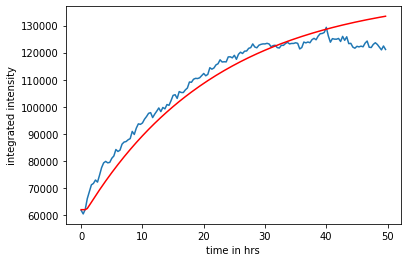

In [444]:
for data in gfp_data[:1]:
    plt.plot(time, data)
plt.xlabel("time in hrs")
plt.ylabel("integrated intensity")
plt.plot(time,out.best_fit,'-r')